In [1]:
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential #Initialise our neural network model as a sequential network
from tensorflow.keras.layers import Conv2D #Convolution operation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation#Applies activation function
from tensorflow.keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from tensorflow.keras.layers import MaxPooling2D # Maxpooling function
from tensorflow.keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from tensorflow.keras.layers import Dense # Regular fully connected neural network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
# First a few tools for this -particular- example...
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

<font size=14pt>CAT MODEL </font> 

In [3]:
# Will grab each image to be processed
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [4]:
# This part will be the input for the model later on, passing pictures into the model for the model to be processed
cat_X = np.concatenate(
 [grab_image('cat_dataset/cat_images/cat_%d.jpg'%(i))
 for i in range(150)])

cat_X.shape

(150, 299, 299, 3)

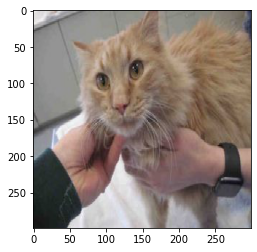

In [5]:
#Prints out first picture of a cat, this one is a long-haired one.
plt.imshow(image.array_to_img(cat_X[0,:,:,:]))
plt.show()

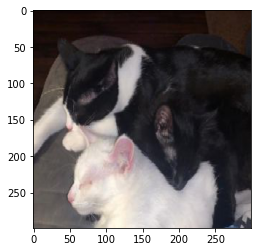

In [6]:
# Prints out the second picture, this one is a short-haired cat
plt.imshow(image.array_to_img(cat_X[1,:,:,:]))
plt.show()

In [7]:
# Let's load up the model
# This will load up the architecture
# and then the pre-trained weights from the
# internet...
cat_model = Xception(weights='imagenet')
cat_model.summary()

2022-05-01 13:58:31.146577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 13:58:31.146642: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 13:58:31.146682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-amj8s): /proc/driver/nvidia/version does not exist
2022-05-01 13:58:31.147125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [8]:
# Just the first image that we say above...
cat_preds = cat_model.predict(cat_X[0:1,:,:,:])
# Decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(cat_preds, top=5)[0])

2022-05-01 13:58:33.582906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Predicted: [('n02123159', 'tiger_cat', 0.5722902), ('n02123045', 'tabby', 0.1436595), ('n02124075', 'Egyptian_cat', 0.040888913), ('n02127052', 'lynx', 0.039072808), ('n02123394', 'Persian_cat', 0.009324582)]


In [9]:
# 150 cats in there (3 Categories- Short, Medium, Long Haired)
cat_Y = np.loadtxt('cat_dataset/cat_data.csv', max_rows=150)
# Take a look at the first 10...
cat_Y[0:10]

array([2., 0., 1., 0., 0., 0., 2., 1., 1., 0.])

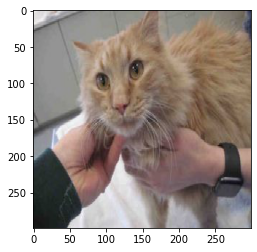

In [10]:
plt.imshow(image.array_to_img(cat_X[0,:,:,:]))
plt.show()

In [12]:
# Where we decide how much are we going to use to train the model and how much is used only for validation - here 
# we use 80% for training and the remaining 20% are the images the model has not seen before for validation
cat_x_train, cat_x_valid, cat_y_train, cat_y_valid = train_test_split(cat_X_train,cat_Y_train, train_size=0.8)

In [16]:
# This is where we create the model for training, will print out the summary for the model (how many layers it has and parameters)

cat_x = keras.layers.Input(cat_x_train.shape[1:])
cat_y = cat_x
cat_y = keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu')(cat_y)
cat_y = keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(cat_y)
cat_y = keras.layers.MaxPooling2D(pool_size=(4,4))(cat_y)
cat_y = keras.layers.Dropout(0.25)(cat_y)
cat_y = keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(cat_y)
cat_y = keras.layers.Flatten()(cat_y)
cat_y = keras.layers.Dropout(0.5)(cat_y)
# Output Logits (10)
cat_y = keras.layers.Dense(len(np.unique(cat_y_train)))(cat_y)
cat_model = keras.Model(cat_x,cat_y)
cat_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0004),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
cat_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 296, 296, 64)      3136      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 293, 293, 128)     131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 70, 70, 128)       262272    
_________________________________________________________________
flatten_1 (Flatten)          (None, 627200)            0     

In [17]:
# This code will provide different transformations for each image so that it can work with more 
cat_dg = keras.preprocessing.image.ImageDataGenerator(
  width_shift_range=0.05,
  height_shift_range=0.05,
  rotation_range=0,
  zoom_range=0,
  horizontal_flip=False)
cat_dg_trainer = cat_dg.flow(cat_x_train,
                        cat_y_train,
                        batch_size=4)

In [18]:
# This code will train the model, will train 20 epochs and try to measure training and validation accuracy of the model.
cat_epochs = 20
cat_history = cat_model.fit(cat_dg_trainer,
                            epochs=cat_epochs,
                            verbose=1,
                            validation_data=(cat_x_valid,cat_y_valid))

Epoch 1/20
30/30 [==============================] - 75s 2s/step - loss: 1.2683 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.1002 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/20
30/30 [==============================] - 73s 2s/step - loss: 1.0925 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.3000
Epoch 3/20
30/30 [==============================] - 71s 2s/step - loss: 1.0903 - sparse_categorical_accuracy: 0.4833 - val_loss: 1.2356 - val_sparse_categorical_accuracy: 0.2667
Epoch 4/20
30/30 [==============================] - 70s 2s/step - loss: 0.9899 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.0660 - val_sparse_categorical_accuracy: 0.4667
Epoch 5/20
30/30 [==============================] - 70s 2s/step - loss: 0.9420 - sparse_categorical_accuracy: 0.5500 - val_loss: 1.6644 - val_sparse_categorical_accuracy: 0.3667
Epoch 6/20
30/30 [==============================] - 71s 2s/step - loss: 0.8587 - sparse_categorical_accuracy: 

In [19]:
# Final Result - Generalization!
# The results will take the highest accuracy of the model and print it out
cat_score = cat_model.evaluate(cat_X_test, cat_Y_test, verbose=1)
print('Test loss:', cat_score[0])
print('Test accuracy:', cat_score[1])

5/5 [==============================] - 11s 2s/step - loss: 0.7204 - sparse_categorical_accuracy: 0.8400
Test loss: 0.7203717231750488
Test accuracy: 0.8399999737739563


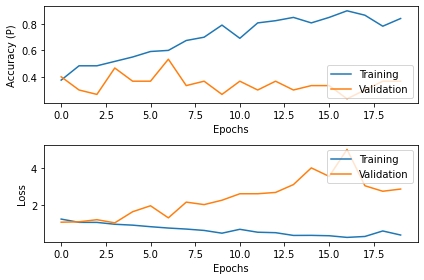

In [20]:
#These plots will graph the accuracy calculated from above so you can see if the model improved over time or not. 

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(cat_history.history['sparse_categorical_accuracy'])
plt.plot(cat_history.history['val_sparse_categorical_accuracy'])
plt.ylabel('Accuracy (P)')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
# summarize history for loss

plt.subplot(212)
plt.plot(cat_history.history['loss'])
plt.plot(cat_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()